# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

2025-08-05 13:06:57.831839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download Sample Data AAPL_2009_4m_training_features_1d (cleaned, not normalized, with features)
data = pd.read_csv('AAPL_2009_4m_training_features_1d.csv')

# 2. Train / Test Split
Now that we have loaded our cleaned price dataset, we are ready to feed the data into our model. With this in mind, we select Close as our singular training feature, and split the data ito train and test data (80/20 split)

In [3]:
# split dataset df into train (80%) and test (20%) datasets

training_rows = int(len(data.index)*0.8)
train_df = data.loc[:training_rows].set_index("Date")
test_df = data.loc[training_rows+1:].set_index("Date")

In [4]:
# display train and test dfs (ensure no overlap)
display_df(train_df.head(5))
display_df(test_df.head(5))

,Close,BB_upper,BB_lower
Date,,,
2009-04-30,4.493929,4.576559,4.040905
2009-05-01,4.544286,4.587013,4.082345
2009-05-04,4.544286,4.606655,4.102880
2009-05-05,4.739643,4.677963,4.082501
2009-05-06,4.732143,4.732943,4.077699


,Close,BB_upper,BB_lower
Date,,,
2009-06-19,4.981429,5.287810,4.542011
2009-06-22,4.906071,5.214837,4.668092
2009-06-23,4.786071,5.200695,4.693770
2009-06-24,4.786071,5.197255,4.700638
2009-06-25,4.995000,5.199378,4.715622


In [5]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)
# print the shape of X_train to remind yourself how many examples and features are in the dataset
print(f"X_train shape: {X_train.shape}")  # Should be (number of training examples, number of features)
print(f"X_test shape: {X_test.shape}")    # Should be (number of testing examples, number of features)

X_train shape: (35, 3)
X_test shape: (8, 3)


# 3. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [6]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        """
        Initializes the DQN agent by creating and compiling a Keras Sequential model
        and storing it as an instance attribute `self.model`.
        """
        # This call is essential for any class that inherits from keras.Model
        super(DQN, self).__init__()

        # --- 1. Define model layers in Keras ---
        # We create a temporary variable `model` to build the Sequential architecture.
        # This matches the prompt's requirements: 64, 32, 8 hidden layers.
        model = keras.Sequential([
            keras.layers.Input(shape=(state_size,)),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(32, activation='relu'),  # Corrected layer
            keras.layers.Dense(8, activation='relu'),   # Added missing layer
            keras.layers.Dense(action_size, activation='linear')
        ])

        # --- 2. Compile model in Keras ---
        # The model is compiled with the specified loss function and optimizer.
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mean_squared_error'  # Mean Squared Error
        )

        # --- 3. Save model to DQN instance ---
        # This final step assigns the fully built and compiled Keras model
        # to the `self.model` attribute, as required by your design.
        self.model = model

    def call(self, inputs):
        """
        Defines the forward pass for the wrapper class.
        This makes the DQN instance itself callable, just like a standard Keras model.
        It simply delegates the action to the internal `self.model`.
        """
        return self.model(inputs)

# --- How to Use This Class ---

# 1. Define your state and action space sizes
state_size = 10  # Example state size (e.g., 10 features)
action_size = 3  # Example action size (Buy, Sell, Hold)

# 2. Create an instance of your DQN agent
# The __init__ method runs automatically, creating and compiling self.model.
dqn_agent = DQN(state_size=state_size, action_size=action_size)

# 3. You can now access the internal model as required by your further code
#    For example, to see the summary or to make predictions.
print("--- Model Summary ---")
dqn_agent.model.summary()

# 4. The dqn_agent is ready for training. Your training loop will likely interact
#    with `dqn_agent.model.predict(...)` and `dqn_agent.model.fit(...)`.
#
#    Example prediction:
#    dummy_state = tf.random.uniform(shape=(1, state_size))
#    predicted_q_values = dqn_agent.model.predict(dummy_state)
#    print(f"\nPredicted Q-values for a dummy state: {predicted_q_values}")

--- Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,075 (12.01 KB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 0 (0.00 B)

### Define Agent Class
Now that we have defined our underlying DQN Model, we must define our Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [ ]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size
        self.num_features = num_features
        self.state_size = window_size * num_features
        self.action_size = 3  # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.test_mode = test_mode

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model
    
    def get_q_values_for_state(self, state):
        # We add verbose=0 to prevent Keras from printing predict status for every call
        return self.model.predict(state.flatten().reshape(1, self.state_size), verbose=0)
    
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, 
                              epochs=1, verbose=0)    
    
    def act(self, state): 
        # Exploration: Choose a random action
        if not self.test_mode and random.random() <= self.epsilon:
            ### --- COMPLETED CODE --- ###
            return random.randrange(self.action_size)

        # Exploitation: Choose the best action based on the model's prediction
        ### --- COMPLETED CODE --- ###
        # Get Q-values for all possible actions from the current state
        q_values = self.get_q_values_for_state(state)
        # Select the action (index) with the highest Q-value
        return np.argmax(q_values[0])
 
    def exp_replay(self, batch_size): # Removed 'losses' parameter, as it should be managed internally
        losses = []
        
        # Do not train if memory is smaller than batch size
        if len(self.memory) < batch_size:
            return losses

        # Randomly sample a mini-batch of past experiences from memory
        mini_batch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in mini_batch:
            # The target Q-value for the action starts as the immediate reward
            target = reward
            
            if not done:
                # If the episode is not over, we add the discounted future reward
                # Predict future rewards from the next_state
                future_q_values = self.get_q_values_for_state(next_state)
                # The optimal future value is the highest Q-value predicted for the next state
                ### --- COMPLETED CODE --- ###
                target = reward + self.gamma * np.amax(future_q_values[0])

            # Get the model's current Q-value predictions for the original state
            ### --- COMPLETED CODE --- ###
            target_q_table = self.get_q_values_for_state(state)
            
            # Update the Q-value for the action that was actually taken with our new target
            target_q_table[0][action] = target
            
            # Fit the model on the (state, target_q_table) pair to teach it the new Q-value
            history = self.fit_model(state, target_q_table)
            losses.extend(history.history['loss'])
           
        # Decay epsilon after each learning batch to shift from exploration to exploitation
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return losses

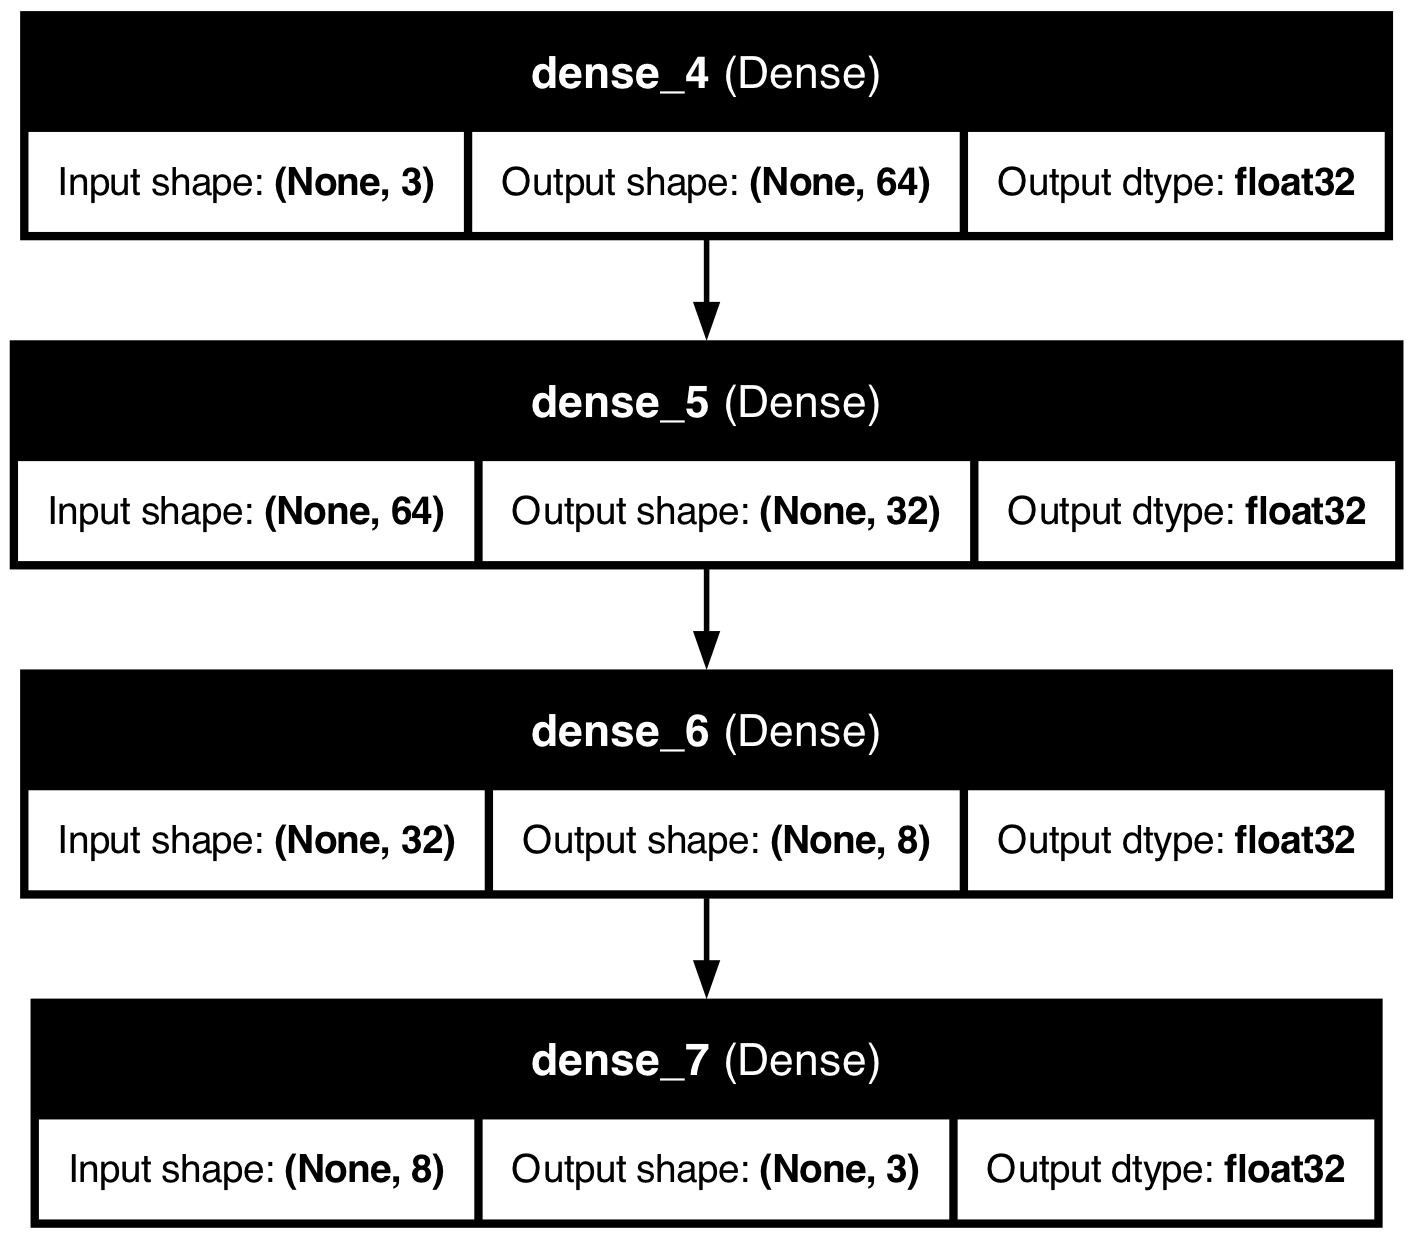

In [8]:
keras.utils.disable_interactive_logging()
from tqdm.notebook import tqdm

window_size = 1
agent = Agent(window_size, num_features=X_train.shape[1])
dot = keras.utils.model_to_dot(
    agent.model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)
dot.write("model.png", format='png')
from IPython import display

display.Image('model.png')